In [1]:
import numpy as np
import gzip
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [2]:
def load(networkx_path):
    with gzip.open(networkx_path, 'rb') as f:
        G = pickle.load(f)
    return G

# Production ready data: './graphs/graph_mf_grc_binary_210519.gz'
# Experimental data (doesn't have same graph format): './graph_mf_grc_synapse_210518_all.gz'
G = load('./graphs/graph_mf_grc_binary_210519.gz')

In [3]:
grc_nodes = [n for n in G.nodes(data=True) if n[1]['cell_type'] == 'grc']
mf_nodes = [n for n in G.nodes(data=True) if n[1]['cell_type'] == 'mf'] 

num_mf = len(np.unique([n[1]['mf_id'] for n in mf_nodes]))
print("Number of GrC: %s" % len(grc_nodes))
print("Number of MFs: %s" % num_mf)
print("Number of MF boutons: %s" % len(mf_nodes))

Number of GrC: 3953
Number of MFs: 729
Number of MF boutons: 1070


In [4]:
z_min = 19800
z_max = 29800
x_min = 105*1000*4
x_max = 135*1000*4

central_grcs = []      
for grc in grc_nodes:
    x, y, z = G.nodes[grc[0]]['xyz']
    # Outside the bounds of observation
    if x < x_min or x > x_max:
        continue
    if z < z_min or z > z_max:
        continue
    central_grcs.append(grc[0]) 

dendrite_lengths = []
for v in central_grcs:
    for u in G.predecessors(v):
        dendrite_lengths.append(scipy.spatial.distance.euclidean(G.nodes[u]['xyz'], G.nodes[v]['xyz']))

In [5]:
rng = np.random.default_rng()

num_boutons = len(mf_nodes)
num_grcs = len(grc_nodes)
# Needs to be larger than number of boutons and GrCs
num_patterns = 10000

# Activity pattern for MF boutons
x_mf = rng.normal(0, 1, size=(num_boutons, num_patterns))

In [6]:
C_mf = np.cov(x_mf)
mf_eigvals = np.linalg.eigvals(C_mf)

In [7]:
def dim(vals):
    top = np.sum(vals) ** 2
    bottom = np.sum(vals ** 2)
    return top / bottom

In [8]:
mf_dim = dim(mf_eigvals)
print(f"Dimensionality of MF: {mf_dim}")

Dimensionality of MF: 966.2010923150985


In [9]:
# Boutons sorted by the MF they belong to and their numbering within the bouton
def bouton_sort(x):
    mf_id_str = x[1]['mf_id'].split("_")[1]
    # Accounting for badly labeled boutons
    if mf_id_str == 'like':
        mf_id_str = x[1]['mf_id'].split("_")[2]
    mf_id = int(mf_id_str)
    bouton_id = int(x[0].split("__")[1])
    return mf_id, bouton_id

# GrC sorted by their index
def grc_sort(x):
    # Accounting for the badly labeled grcs
    if x[0].split("_")[1] == 'dendrite':
        return int(x[0].split("_")[2])
    return int(x[0].split("_")[1])

sorted_boutons = sorted(mf_nodes, key=bouton_sort)
sorted_grcs = sorted(grc_nodes, key=grc_sort)

all_sorted = []
all_sorted.extend(sorted_boutons)
all_sorted.extend(sorted_grcs)

names = [n[0] for n in all_sorted]
# Take in undirected view so we can index the boutons corresponding to a specific GrC
adj = nx.to_scipy_sparse_array(G.to_undirected(as_view=True), nodelist=names)
new_adj = adj[:num_boutons, num_boutons:num_boutons+num_grcs]
trans_x = x_mf.transpose()
grc_pre_threshold = trans_x @ new_adj
grc_pre_threshold = grc_pre_threshold.transpose()

In [10]:
def erdos_renyi():
    num_presyn = len(mf_nodes)
    num_postsyn = len(grc_nodes)
    edge_prob = len(G.edges) / (num_presyn * num_postsyn)
    erdos_renyi_graph = nx.bipartite.random_graph(num_presyn, num_postsyn, edge_prob, directed=True)
    
    attributes = [n[1] for n in all_sorted]
    old_mapping = list(range(len(erdos_renyi_graph.nodes)))
    new_mapping = names
    random_model = nx.relabel_nodes(erdos_renyi_graph, dict(zip(old_mapping, new_mapping)))
    nx.set_node_attributes(random_model, dict(zip(names, attributes)))
    return random_model

In [11]:
# Configuration fixing both outdegree of bouton and indegree of GrC
def fixed_mf_grc():
    bouton_outdegrees = list(map(lambda x: G.out_degree(x[0]), sorted_boutons))
    grc_indegrees = list(map(lambda x: G.in_degree(x[0]), sorted_grcs))
    
    attributes = [n[1] for n in all_sorted]
    
    random_model = nx.bipartite.configuration_model(bouton_outdegrees, grc_indegrees, create_using=nx.Graph())
    
    old_mapping = list(range(len(random_model.nodes)))
    new_mapping = names
    random_model = nx.relabel_nodes(random_model, dict(zip(old_mapping, new_mapping)))
    nx.set_node_attributes(random_model, dict(zip(names, attributes)))
    
    # Created directed graph from undirected random model
    dir_random_model = nx.create_empty_copy(G, with_data=True)
    dir_random_model.add_edges_from(random_model.edges)
    
    return dir_random_model

In [12]:
def radius_random_model(radius_factor):
    mu = np.mean(dendrite_lengths) 
    radius = radius_factor * mu
    random_model = nx.create_empty_copy(G, with_data=True)
    rand = np.random.default_rng()
    for g in grc_nodes:
        grc = g[0]
        candidates = []
        for b in mf_nodes:
            bouton = b[0]
            if scipy.spatial.distance.euclidean(G.nodes[bouton]['xyz'], G.nodes[grc]['xyz']) <= radius:
                candidates.append(bouton)
        if len(candidates) > 0:
            sample_size = G.in_degree(grc)
            if len(candidates) < sample_size:
                sample_size = len(candidates)
            sample = rand.choice(candidates, size=sample_size, replace=False)
            for s in sample:
                random_model.add_edge(s, grc)
    return random_model

In [13]:
# Creates pre-thresholding GrC activity matrix for a given graph and MF activity matrix
def construct_activity(graph, mf_activity):
    weights = nx.to_scipy_sparse_array(graph.to_undirected(as_view=True), nodelist=names)
    weights_slice = weights[:num_boutons, num_boutons:num_boutons+num_grcs]
    pre_threshold = mf_activity.transpose() @ weights_slice
    pre_threshold = pre_threshold.transpose()
    
    return pre_threshold

In [57]:
def threshold_activity(p, sorted_threshold_matrix, pre_threshold_matrix):
    threshold_index = int((1 - p) * num_patterns)
    thetas = np.expand_dims(sorted_threshold_matrix[:, threshold_index], 1)
    grc_post_threshold = pre_threshold_matrix - thetas
    grc_activity = np.heaviside(grc_post_threshold, 1)
    
    return grc_activity

In [58]:
def dim_for_coding_level(pre_threshold_matrix, coding_levels):
    dim_vals = []
    sorted_threshold_matrix = np.sort(pre_threshold_matrix, axis=1)
    # Coding level (percentage of patterns for which a GrC fires)
    for p in coding_levels:
        grc_activity = threshold_activity(p, sorted_threshold_matrix, pre_threshold_matrix)
        
        C_grc = np.cov(grc_activity)
        grc_eigvals = np.linalg.eigvals(C_grc)
        grc_dim = dim(grc_eigvals)
        # Get real part of complex eigenvalue
        dim_real = grc_dim.real
        print(f"Coding level: {p}, Dimensionality: {dim_real}")
        dim_vals.append(dim_real)
        
    return dim_vals

In [15]:
codings = np.arange(1, 11, 1) / 100
reconstructed_dims = dim_for_coding_level(grc_pre_threshold, codings)

Coding level: 0.01, Dimensionality: 2019.2183418495006
Coding level: 0.02, Dimensionality: 1886.3881054789556
Coding level: 0.03, Dimensionality: 1786.154304230503
Coding level: 0.04, Dimensionality: 1703.4202518350335
Coding level: 0.05, Dimensionality: 1633.6311013683546
Coding level: 0.06, Dimensionality: 1574.0850423653799
Coding level: 0.07, Dimensionality: 1522.6904139921926
Coding level: 0.08, Dimensionality: 1478.1082588428978
Coding level: 0.09, Dimensionality: 1437.7967793920604
Coding level: 0.1, Dimensionality: 1401.8932918278867


In [16]:
fixed_degree_model = fixed_mf_grc()
fixed_degree_dims = dim_for_coding_level(construct_activity(fixed_degree_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 2266.1557074331827
Coding level: 0.02, Dimensionality: 2113.5267952765244
Coding level: 0.03, Dimensionality: 1992.7761256696076
Coding level: 0.04, Dimensionality: 1895.007226548064
Coding level: 0.05, Dimensionality: 1812.776403722798
Coding level: 0.06, Dimensionality: 1742.788195144016
Coding level: 0.07, Dimensionality: 1681.7547525753882
Coding level: 0.08, Dimensionality: 1629.2847095586653
Coding level: 0.09, Dimensionality: 1582.2989688089372
Coding level: 0.1, Dimensionality: 1540.7256967091935


In [17]:
# Avg radius, for now don't use radius factor
radius_model = radius_random_model(1)
radius_model_dims = dim_for_coding_level(construct_activity(radius_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 2044.267029349883
Coding level: 0.02, Dimensionality: 1927.6568064051803
Coding level: 0.03, Dimensionality: 1836.3042156086037
Coding level: 0.04, Dimensionality: 1762.3965571374572
Coding level: 0.05, Dimensionality: 1700.117448716114
Coding level: 0.06, Dimensionality: 1647.2010812174312
Coding level: 0.07, Dimensionality: 1600.57659888124
Coding level: 0.08, Dimensionality: 1559.5870244167818
Coding level: 0.09, Dimensionality: 1522.640541298196
Coding level: 0.1, Dimensionality: 1489.9995028563148


In [18]:
erdos_renyi_model = erdos_renyi()
erdos_renyi_dims = dim_for_coding_level(construct_activity(erdos_renyi_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 2678.795040890138
Coding level: 0.02, Dimensionality: 2577.595924902968
Coding level: 0.03, Dimensionality: 2476.759586909581
Coding level: 0.04, Dimensionality: 2383.252570622967
Coding level: 0.05, Dimensionality: 2297.3111972681477
Coding level: 0.06, Dimensionality: 2219.4061140248923
Coding level: 0.07, Dimensionality: 2148.341174636921
Coding level: 0.08, Dimensionality: 2083.5029202035544
Coding level: 0.09, Dimensionality: 2024.9385823040718
Coding level: 0.1, Dimensionality: 1971.1443012807126


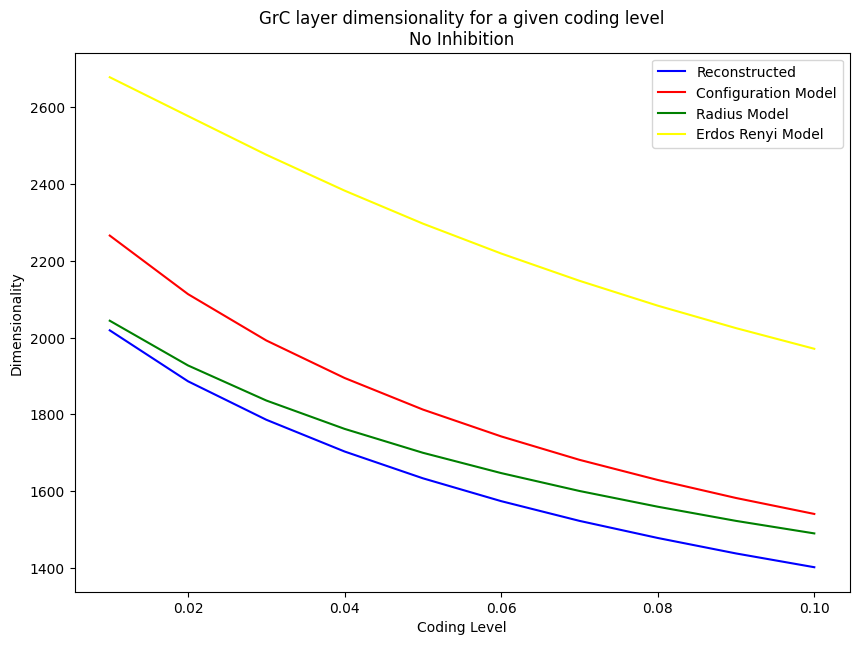

In [19]:
fig = plt.figure(figsize=(10, 7))
plt.plot(codings, reconstructed_dims, color='blue', label='Reconstructed')
plt.plot(codings, fixed_degree_dims, color='red', label='Configuration Model')
plt.plot(codings, radius_model_dims, color='green', label='Radius Model')
plt.plot(codings, erdos_renyi_dims, color='yellow', label='Erdos Renyi Model')
plt.xlabel("Coding Level")
plt.ylabel("Dimensionality")
plt.title("GrC layer dimensionality for a given coding level\nNo Inhibition")
plt.legend()
plt.savefig("./figures/model_dimensionalities.png")
plt.show()
plt.close(fig)

In [20]:
# Creates pre-thresholding GrC activity matrix for a given graph and MF activity matrix
def activity_w_inhibition(graph, mf_activity):
    weights = nx.to_scipy_sparse_array(graph.to_undirected(as_view=True), nodelist=names)
    weights_slice = weights[:num_boutons, num_boutons:num_boutons+num_grcs]
    pre_threshold = mf_activity.transpose() @ weights_slice
    
    k = np.mean([t[1] for t in G.in_degree(central_grcs)])
    n = len(mf_nodes)
    
    inhib_const = k / n
    
    inhib_arr = inhib_const * np.sum(x_mf, axis=0)
    inhib_arr = np.expand_dims(inhib_arr, axis=1)
    pre_threshold = pre_threshold - inhib_arr
    pre_threshold = pre_threshold.transpose()
    
    return pre_threshold

In [21]:
reconst_w_inhib = dim_for_coding_level(activity_w_inhibition(G, x_mf), codings)

Coding level: 0.01, Dimensionality: 1855.5140705483948
Coding level: 0.02, Dimensionality: 1745.8562075461423
Coding level: 0.03, Dimensionality: 1659.3153385684889
Coding level: 0.04, Dimensionality: 1588.0885037537857
Coding level: 0.05, Dimensionality: 1527.3348218406804
Coding level: 0.06, Dimensionality: 1475.3676893589188
Coding level: 0.07, Dimensionality: 1430.5090549012234
Coding level: 0.08, Dimensionality: 1390.7197286115993
Coding level: 0.09, Dimensionality: 1355.2700444051502
Coding level: 0.1, Dimensionality: 1323.4963491282008


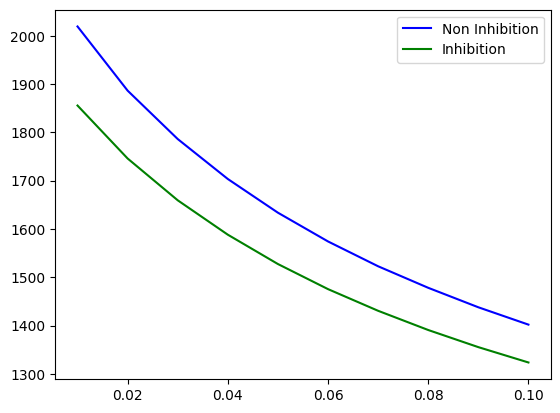

In [22]:
plt.plot(codings, reconstructed_dims, color='blue', label='Non Inhibition')
plt.plot(codings, reconst_w_inhib, color='green', label='Inhibition')
plt.legend()
plt.show()

In [23]:
fixed_degree_model = fixed_mf_grc()
fixed_degree_dims_inhib = dim_for_coding_level(activity_w_inhibition(fixed_degree_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 2083.176250811505
Coding level: 0.02, Dimensionality: 1954.821100779786
Coding level: 0.03, Dimensionality: 1854.5366789624632
Coding level: 0.04, Dimensionality: 1770.085422340864
Coding level: 0.05, Dimensionality: 1699.5951818556925
Coding level: 0.06, Dimensionality: 1639.1597002789129
Coding level: 0.07, Dimensionality: 1585.7589646486338
Coding level: 0.08, Dimensionality: 1538.2826265155122
Coding level: 0.09, Dimensionality: 1496.4431908126287
Coding level: 0.1, Dimensionality: 1458.8920519536002


In [24]:
radius_model = radius_random_model(1)
radius_model_dims_inhib = dim_for_coding_level(activity_w_inhibition(radius_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 1781.8367626902718
Coding level: 0.02, Dimensionality: 1696.816199215481
Coding level: 0.03, Dimensionality: 1625.673417447634
Coding level: 0.04, Dimensionality: 1567.3617675573348
Coding level: 0.05, Dimensionality: 1517.7965518887847
Coding level: 0.06, Dimensionality: 1474.991839577904
Coding level: 0.07, Dimensionality: 1436.7942979952345
Coding level: 0.08, Dimensionality: 1403.555104725842
Coding level: 0.09, Dimensionality: 1373.7002230537535
Coding level: 0.1, Dimensionality: 1346.1429826566377


In [25]:
erdos_renyi_model = erdos_renyi()
erdos_renyi_dims_inhib = dim_for_coding_level(activity_w_inhibition(erdos_renyi_model, x_mf), codings)

Coding level: 0.01, Dimensionality: 2686.291280039476
Coding level: 0.02, Dimensionality: 2583.1926351128136
Coding level: 0.03, Dimensionality: 2483.664835152262
Coding level: 0.04, Dimensionality: 2390.9416346447347
Coding level: 0.05, Dimensionality: 2306.786932104766
Coding level: 0.06, Dimensionality: 2230.104100003996
Coding level: 0.07, Dimensionality: 2160.0651261718276
Coding level: 0.08, Dimensionality: 2097.227359501109
Coding level: 0.09, Dimensionality: 2038.9688398819442
Coding level: 0.1, Dimensionality: 1985.3855915314339


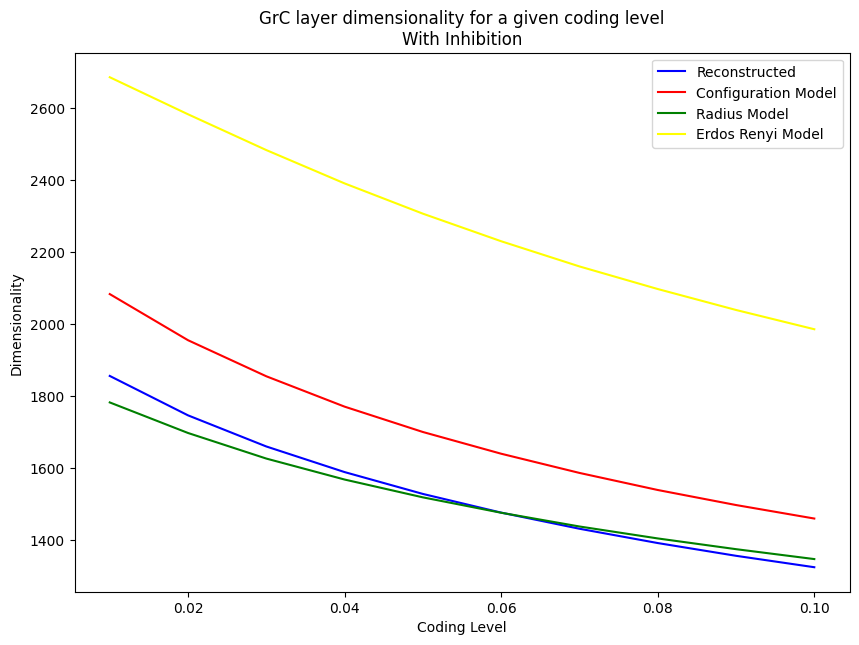

In [26]:
fig = plt.figure(figsize=(10, 7))
plt.plot(codings, reconst_w_inhib, color='blue', label='Reconstructed')
plt.plot(codings, fixed_degree_dims_inhib, color='red', label='Configuration Model')
plt.plot(codings, radius_model_dims_inhib, color='green', label='Radius Model')
plt.plot(codings, erdos_renyi_dims_inhib, color='yellow', label='Erdos Renyi Model')
plt.xlabel("Coding Level")
plt.ylabel("Dimensionality")
plt.title("GrC layer dimensionality for a given coding level\nWith Inhibition")
plt.legend()
plt.show()
plt.close(fig)

In [27]:
# Variance in MF noise
var = 0.1
num_noise = 10000
# Which pattern to choose
pattern_num = 0
x_mf_p = x_mf[:, pattern_num]
# Only look at one pattern
x_pattern = np.expand_dims(x_mf_p, axis=1)
noise = rng.normal(0, var, size=(num_boutons, num_noise))
noisy_x = x_pattern + noise
del_x_top = np.mean(np.sum((noisy_x - x_pattern) ** 2, axis=0))

# k = 1 so we don't take the diagonal (i.e pairs of the same values)
i, j = np.triu_indices(num_boutons, k=1)
x_pattern_inds = np.vstack((i, j)).transpose()
c = np.take(x_mf, x_pattern_inds, axis=1)
# Each pair is now on the first axis
d = np.transpose(c, (1, 0, 2))
# After taking the diff, remove that axis 
e = np.squeeze(np.diff(d, axis=2), axis=2)
f = np.sum(np.square(e), axis=1)
del_x_bottom = np.mean(f)

In [28]:
print(f"Noise for MF input: {del_x_top / del_x_bottom}")

Noise for MF input: 0.004994739120198286


In [59]:
# Which mf activity pattern to choose from when selecting noise
def mf_noisy_activity(mf_activity, pattern: int):
    # Only look at one pattern
    mf_pattern = np.expand_dims(mf_activity[:, pattern], axis=1)
    x_noise = rng.normal(0, var, size=(num_boutons, num_noise))
    noisy_pattern = mf_pattern + x_noise
    
    return noisy_pattern

In [60]:
def grc_noise_top(grc_activity, noisy_grc_activity, pattern: int):
    # Only look at one pattern
    grc_pattern = np.expand_dims(grc_activity[:, pattern], axis=1)
    
    del_grc_top = np.mean(np.sum((noisy_grc_activity - grc_pattern) ** 2, axis=0))
    return del_grc_top

In [61]:
def grc_noise_bottom(grc_activity):
    i, j = np.triu_indices(num_grcs, k=1)
    grc_inds = np.vstack((i, j)).transpose()
    # Only take set of pairs which is same length as the MF pattern pairs
    # (otherwise computation takes too long)
    subset = x_pattern_inds.shape[0]
    grc_subset_inds = grc_inds[:subset]
    
    c = np.take(grc_activity, grc_subset_inds, axis=1)
    # Each pair is now on the first axis
    d = np.transpose(c, (1, 0, 2))
    # After taking the diff, remove that axis 
    e = np.squeeze(np.diff(d, axis=2), axis=2)
    f = np.sum(np.square(e), axis=1)
    del_grc_bottom = np.mean(f)
    return del_grc_bottom

In [62]:
def grc_noise_for_coding_level(G, mf_activity, coding_levels, inhib: bool):
    noise_vals = []
    
    pattern_num = 0
    if not inhib:
        pre_threshold_matrix = construct_activity(G, mf_activity)
        noisy_pre_threshold_matrix = construct_activity(G, mf_noisy_activity(mf_activity, pattern=pattern_num))
    else:
        pre_threshold_matrix = activity_w_inhibition(G, mf_activity)
        noisy_pre_threshold_matrix = activity_w_inhibition(G, mf_noisy_activity(mf_activity, pattern=pattern_num))
    
    sorted_threshold_matrix = np.sort(pre_threshold_matrix, axis=1)
    sorted_noisy_threshold_matrix = np.sort(noisy_pre_threshold_matrix, axis=1)
    
    for p in coding_levels:
        grc_activity = threshold_activity(p, sorted_threshold_matrix, pre_threshold_matrix)
        noisy_grc_activity = threshold_activity(p, sorted_noisy_threshold_matrix, noisy_pre_threshold_matrix)
        
        del_grc_top = grc_noise_top(grc_activity, noisy_grc_activity, pattern=pattern_num)
        del_grc_bottom = grc_noise_bottom(grc_activity)
        del_grc = del_grc_top / del_grc_bottom
        print(f"Coding level: {p}, Noise: {del_grc}")
        noise_vals.append(del_grc)
   
    return noise_vals

In [63]:
print("No Inhibition:")
reconstr_noise = grc_noise_for_coding_level(G, x_mf, codings, inhib=False)
print("Inhibition:")
reconstr_inhib_noise = grc_noise_for_coding_level(G, x_mf, codings, inhib=True)

No Inhibition:
Coding level: 0.01, Noise: 0.848760958752882
Coding level: 0.02, Noise: 0.8959414087838586
Coding level: 0.03, Noise: 0.8853038144089198
Coding level: 0.04, Noise: 0.8763231202448472
Coding level: 0.05, Noise: 0.8854820695678012
Coding level: 0.06, Noise: 0.909440159663825
Coding level: 0.07, Noise: 0.9201889134621902
Coding level: 0.08, Noise: 0.9234708018505464
Coding level: 0.09, Noise: 0.922295810174025
Coding level: 0.1, Noise: 0.9262434691602537
Inhibition:
Coding level: 0.01, Noise: 0.9378025225136487
Coding level: 0.02, Noise: 0.961649996425005
Coding level: 0.03, Noise: 0.9528690076649607
Coding level: 0.04, Noise: 0.9413119826827901
Coding level: 0.05, Noise: 0.969085254811613
Coding level: 0.06, Noise: 0.9655931615346115
Coding level: 0.07, Noise: 0.9756783191712691
Coding level: 0.08, Noise: 0.9678199508038251
Coding level: 0.09, Noise: 0.9658908106329682
Coding level: 0.1, Noise: 0.9813425138974836


In [64]:
radius_model = radius_random_model(1)
print("No Inhibition:")
radius_model_noise = grc_noise_for_coding_level(radius_model, x_mf, codings, inhib=False)
print("Inhibition:")
radius_model_inhib_noise = grc_noise_for_coding_level(radius_model, x_mf, codings, inhib=True)

No Inhibition:
Coding level: 0.01, Noise: 0.820489767817556
Coding level: 0.02, Noise: 0.8649855767740912
Coding level: 0.03, Noise: 0.8419153861782671
Coding level: 0.04, Noise: 0.8617500556689404
Coding level: 0.05, Noise: 0.8854113618860378
Coding level: 0.06, Noise: 0.8871836544648656
Coding level: 0.07, Noise: 0.9185786904278782
Coding level: 0.08, Noise: 0.9179343012663952
Coding level: 0.09, Noise: 0.9359322709045199
Coding level: 0.1, Noise: 0.9285742802872673
Inhibition:
Coding level: 0.01, Noise: 0.876127194132172
Coding level: 0.02, Noise: 0.9294325507343619
Coding level: 0.03, Noise: 0.9062558338322434
Coding level: 0.04, Noise: 0.9329349788696718
Coding level: 0.05, Noise: 0.9443605615733547
Coding level: 0.06, Noise: 0.9674948585318118
Coding level: 0.07, Noise: 0.970370173391572
Coding level: 0.08, Noise: 0.9762275443204933
Coding level: 0.09, Noise: 0.9736090021133628
Coding level: 0.1, Noise: 0.9835461045566509


In [65]:
config_model = fixed_mf_grc()
print("No Inhibition:")
config_model_noise = grc_noise_for_coding_level(config_model, x_mf, codings, inhib=False)
print("Inhibition:")
config_model_inhib_noise = grc_noise_for_coding_level(config_model, x_mf, codings, inhib=True)

No Inhibition:
Coding level: 0.01, Noise: 0.8481347743716003
Coding level: 0.02, Noise: 0.8722893076839116
Coding level: 0.03, Noise: 0.8823339093164433
Coding level: 0.04, Noise: 0.9162865835706102
Coding level: 0.05, Noise: 0.9077192454160591
Coding level: 0.06, Noise: 0.910248527936642
Coding level: 0.07, Noise: 0.9193233779808707
Coding level: 0.08, Noise: 0.920881994463172
Coding level: 0.09, Noise: 0.9337925794836605
Coding level: 0.1, Noise: 0.945515356607538
Inhibition:
Coding level: 0.01, Noise: 0.9134812201486339
Coding level: 0.02, Noise: 0.9509628810572512
Coding level: 0.03, Noise: 0.9758632282858455
Coding level: 0.04, Noise: 0.9747457030455972
Coding level: 0.05, Noise: 0.9548076003491475
Coding level: 0.06, Noise: 0.9740603196710774
Coding level: 0.07, Noise: 0.9812004888277945
Coding level: 0.08, Noise: 0.9872242173447192
Coding level: 0.09, Noise: 0.992367836145451
Coding level: 0.1, Noise: 0.9881046123889433


In [66]:
erdos_renyi_model = erdos_renyi()
print("No Inhibition:")
erdos_model_noise = grc_noise_for_coding_level(erdos_renyi_model, x_mf, codings, inhib=False)
print("Inhibition:")
erdos_model_inhib_noise = grc_noise_for_coding_level(erdos_renyi_model, x_mf, codings, inhib=True)

No Inhibition:
Coding level: 0.01, Noise: 0.9159322384840615
Coding level: 0.02, Noise: 0.9190426879009508
Coding level: 0.03, Noise: 0.9166916924361567
Coding level: 0.04, Noise: 0.8915826593533648
Coding level: 0.05, Noise: 0.9132714916363598
Coding level: 0.06, Noise: 0.926119988085287
Coding level: 0.07, Noise: 0.9317582029356913
Coding level: 0.08, Noise: 0.9432146251663326
Coding level: 0.09, Noise: 0.9476774090456503
Coding level: 0.1, Noise: 0.9564235708262491
Inhibition:
Coding level: 0.01, Noise: 0.9629729766896913
Coding level: 0.02, Noise: 0.9687027636966716
Coding level: 0.03, Noise: 0.9590951053574942
Coding level: 0.04, Noise: 0.9443135370328711
Coding level: 0.05, Noise: 0.9596038798808341
Coding level: 0.06, Noise: 0.9752649810441699
Coding level: 0.07, Noise: 0.9773090312628205
Coding level: 0.08, Noise: 0.983004826524702
Coding level: 0.09, Noise: 0.9960288955742737
Coding level: 0.1, Noise: 0.9908892658417607


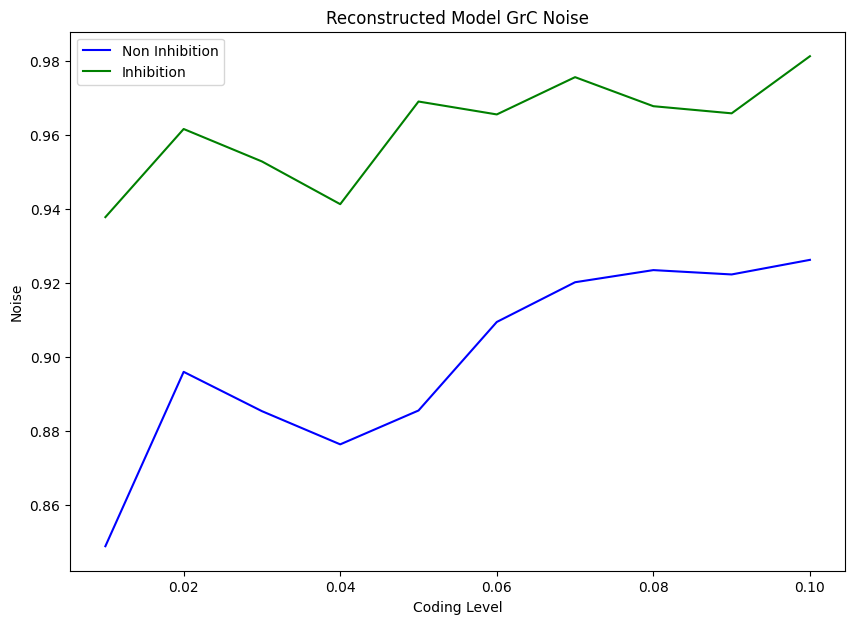

In [67]:
fig = plt.figure(figsize=(10, 7))
plt.plot(codings, reconstr_noise, color='blue', label='Non Inhibition')
plt.plot(codings, reconstr_inhib_noise, color='green', label='Inhibition')
plt.title("Reconstructed Model GrC Noise")
plt.xlabel("Coding Level")
plt.ylabel("Noise")
plt.legend()
plt.show()
plt.close(fig)

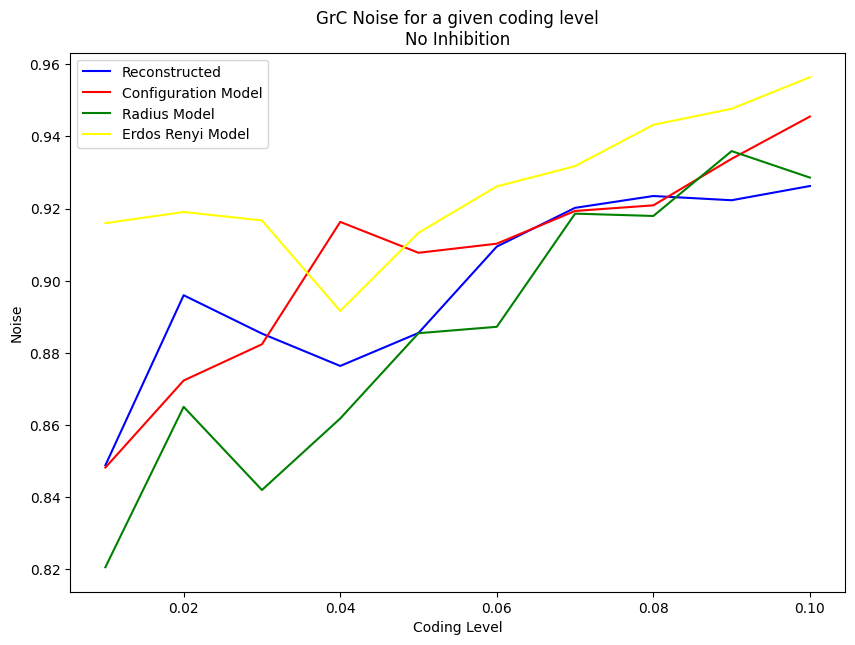

In [68]:
fig = plt.figure(figsize=(10, 7))
plt.plot(codings, reconstr_noise, color='blue', label='Reconstructed')
plt.plot(codings, config_model_noise, color='red', label='Configuration Model')
plt.plot(codings, radius_model_noise, color='green', label='Radius Model')
plt.plot(codings, erdos_model_noise, color='yellow', label='Erdos Renyi Model')
plt.xlabel("Coding Level")
plt.ylabel("Noise")
plt.title("GrC Noise for a given coding level\nNo Inhibition")
plt.legend()
plt.show()
plt.close(fig)

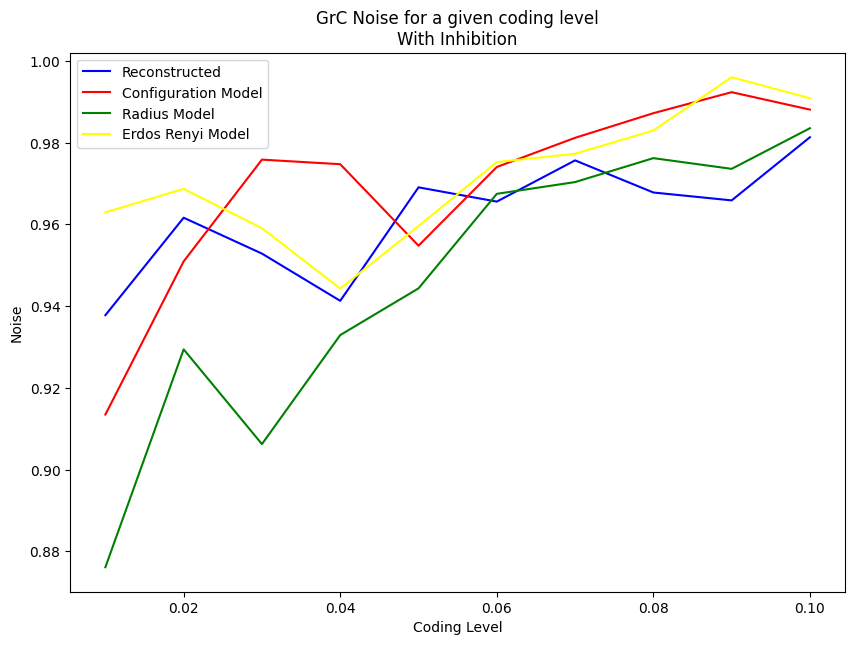

In [69]:
fig = plt.figure(figsize=(10, 7))
plt.plot(codings, reconstr_inhib_noise, color='blue', label='Reconstructed')
plt.plot(codings, config_model_inhib_noise, color='red', label='Configuration Model')
plt.plot(codings, radius_model_inhib_noise, color='green', label='Radius Model')
plt.plot(codings, erdos_model_inhib_noise, color='yellow', label='Erdos Renyi Model')
plt.xlabel("Coding Level")
plt.ylabel("Noise")
plt.title("GrC Noise for a given coding level\nWith Inhibition")
plt.legend()
plt.show()
plt.close(fig)